In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv("pendigits.tra", header = None)
df_test = pd.read_csv("pendigits.tes", header = None)

In [3]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,82,9,59,56,34,41,0,10,30,3,67,42,96,100,100,5
7490,49,100,0,70,24,56,100,65,86,85,44,77,21,38,6,0,4
7491,100,98,60,100,24,87,3,58,35,51,58,26,36,0,0,5,5
7492,59,65,91,100,84,96,72,50,51,8,0,0,45,1,100,0,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7494 non-null   int64
 1   1       7494 non-null   int64
 2   2       7494 non-null   int64
 3   3       7494 non-null   int64
 4   4       7494 non-null   int64
 5   5       7494 non-null   int64
 6   6       7494 non-null   int64
 7   7       7494 non-null   int64
 8   8       7494 non-null   int64
 9   9       7494 non-null   int64
 10  10      7494 non-null   int64
 11  11      7494 non-null   int64
 12  12      7494 non-null   int64
 13  13      7494 non-null   int64
 14  14      7494 non-null   int64
 15  15      7494 non-null   int64
 16  16      7494 non-null   int64
dtypes: int64(17)
memory usage: 995.4 KB


In [5]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000
mean,37.384307,84.679343,40.005604,82.889512,50.878303,65.044436,51.471844,44.599680,57.129971,34.069122,61.417401,35.782092,54.699760,35.800774,46.813718,28.565386,4.430878
std,33.322024,16.848420,26.256025,19.638582,34.927201,27.377341,30.680075,30.659478,33.680340,27.459989,37.130762,27.495836,22.599781,33.223611,41.531794,35.811094,2.876981
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,76.000000,20.000000,70.000000,17.000000,48.000000,28.000000,22.000000,30.000000,7.000000,25.000000,12.000000,41.000000,7.000000,0.000000,0.000000,2.000000
50%,31.000000,89.000000,39.000000,89.000000,56.000000,71.000000,54.000000,42.000000,60.000000,33.000000,74.000000,32.000000,53.000000,28.000000,39.000000,8.000000,4.000000
75%,61.000000,100.000000,58.000000,100.000000,81.000000,86.000000,75.000000,65.000000,88.000000,55.000000,98.000000,57.000000,69.000000,48.000000,100.000000,51.000000,7.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,9.000000


In [6]:
import plotly.figure_factory as ff
import plotly.graph_objs as go

def plot_correlation(df):
    '''
    This function is resposible to plot a correlation map among features in the dataset
    '''
    corr = np.round(df.corr(), 2)
    mask = np.triu(np.ones_like(corr, dtype = bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])

    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale = 'bluyl')

    fig.update_layout(title = {'text': '<b>Feature Correlation <br> <sup>Heatmap</sup></b>'},
                      height = 650, width = 650,
                      margin = dict(t=210, l = 80),
                      template = 'simple_white',
                      yaxis = dict(autorange = 'reversed'))

    fig.add_trace(go.Heatmap(z = c[::-1],
                             colorscale = 'bluyl',
                             showscale = True,
                             visible = False))
    fig.data[1].visible = True

    fig.show()

In [7]:
plot_correlation(df_train)

In [14]:
seed = 42
plotly_template = 'simple_white'
from plotly.subplots import make_subplots
def plot_histogram_matrix(df):
    
    '''
    This function identifies all continuous features within the dataset and plots
    a matrix of histograms for each attribute
    '''
    
    continuous_features = []
    for feat in df.columns:
        if df[feat].nunique() > 2:
            continuous_features.append(feat)
    num_cols = 2
    num_rows = (len(continuous_features) + 1) // num_cols

    fig = make_subplots(rows=num_rows, cols=num_cols)

    for i, feature in enumerate(continuous_features):
        row = i // num_cols + 1
        col = i % num_cols + 1

        fig.add_trace(
            go.Histogram(
                x=df[feature],
                name=feature
            ),
            row=row,
            col=col
        )

        fig.update_xaxes(title_text=feature, row=row, col=col)
        fig.update_yaxes(title_text='Frequency', row=row, col=col)
        fig.update_layout(
            title=f'<b>Histogram Matrix<br> <sup> Continuous Features</sup></b>',
            showlegend=False
        )

    fig.update_layout(
        height=150 * num_rows,
        width=500,
        margin=dict(t=100, l=80),
        template= plotly_template
    )

    fig.show()

In [17]:
plot_histogram_matrix(df_train)

In [50]:
import plotly.express as px
def barplot(df, feat):    
    
    '''
    This function is supposed to organize the n top value counts of any attribute and plot a Barplot
    '''
    
    counts = df[feat].value_counts()
    fig = px.bar(y=counts.values, 
                 x=counts.index, 
                 #color = counts.index,
                 text=counts.values)

    fig.update_layout(title=f'<b>Frequency of values in labels<br> <sup> Barplot</sup></b>',
                      xaxis=dict(title=f'{feat}'),
                      yaxis=dict(title='Count'),
                      legend=dict(title=f'{feat}'),
                      showlegend=True,
                      height=300,
                      width=500,
                      margin=dict(t=100, l=80),
                      template= plotly_template)
    fig.show()

In [42]:
counts = df_train[16].value_counts()
counts.index[::-1]

Index([3, 9, 8, 5, 6, 7, 1, 0, 4, 2], dtype='int64', name=16)

In [51]:
label, count = np.unique(df_train.iloc[:,16], return_counts=True)
print(pd.DataFrame(count,index=label,columns=['Counts']).transpose())
barplot(df_train,16)

          0    1    2    3    4    5    6    7    8    9
Counts  780  779  780  719  780  720  720  778  719  719


In [52]:
x_train = df_train.iloc[:,:16]
y_train = df_train.iloc[:,16]
x_test = df_test.iloc[:,:16]
y_test = df_test[16]

In [53]:
print(f"Shape of x_train: {x_train.shape} and shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape} and shape of y_test: {y_test.shape}")

Shape of x_train: (7494, 16) and shape of y_train: (7494,)
Shape of x_test: (3498, 16) and shape of y_test: (3498,)


In [ ]:
from sklearn import preprocessing
normalized_x_train = pd.DataFrame(preprocessing.normalize(x_train))
normalized_x_test = pd.DataFrame(preprocessing.normalize(x_test))
normalized_x_train

In [54]:
import numpy as np
import sys
class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
 
 
    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch
        if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.
 
    Attributes
    -----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training.
 
    """
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
 
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
 
        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
 
        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)
 
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
 
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
 
    def _forward(self, X):
        """Compute forward propagation step"""
 
        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
 
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
 
        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
 
        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
 
        return z_h, a_h, z_out, a_out
 
    def _compute_cost(self, y_enc, output):
        """Compute cost function.
 
        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)
 
        Returns
        ---------
        cost : float
            Regularized cost
 
        """
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
 
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        
        """Predict class labels
 
        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.
 
        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.
 
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
 
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.
 
        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training
 
        Returns:
        ----------
        self
 
        """
        n_output = np.unique(y_train).shape[0] # no. of class
        #labels
        n_features = X_train.shape[1]
 
        ########################
        # Weight initialization
        ########################
 
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
 
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
 
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
 
        y_train_enc = self._onehot(y_train, n_output)
 
        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                bb = X_train.iloc[batch_idx]
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(bb)
                
                ##################
                # Backpropagation
                ##################
                
                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]
                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_examples, n_classlabels] dot [n_classlabels,
                # n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)
                
                # [n_features, n_examples] dot [n_examples,
                # n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train.iloc[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                # [n_hidden, n_examples] dot [n_examples,
                # n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            #############
            # Evaluation
            #############
            
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
            output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f ' '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
            (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        
        return self


In [55]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)

In [56]:
nn.fit(X_train=x_train, y_train=y_train, X_valid=x_test[:1873], y_valid=y_test[:1873])

200/200 | Cost: 470.63 | Train/Valid Acc.: 99.60%/96.32%   

In [57]:
y_test_pred = nn.predict(x_test[1873:])
acc = (np.sum(y_test[1873:] == y_test_pred).astype(float) / x_test[1873:].shape[0])
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 96.43%


In [77]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=500, activation='logistic').fit(x_train, y_train)
y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

0.9739851343624929

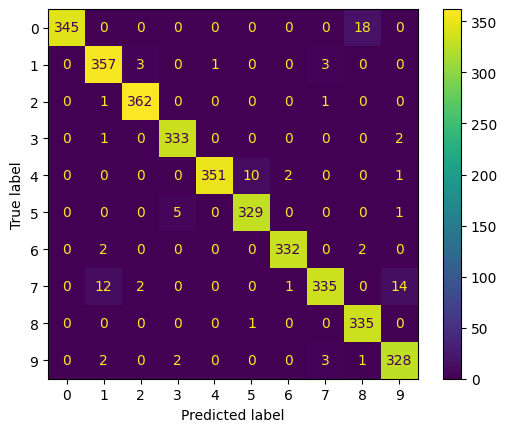

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
#fig, ax = plt.subplots()
#ConfusionMatrixDisplay(clf, x_test, y_test, display_labels=clf.classes_, ax=ax, cmap=plt.cm.Blues, values_format='d')
#fig.suptitle(f"Confusion Matrix for MLPClassifier")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [ ]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()